# Example Codes

Dependencies

In [1]:
%pip install numpy scipy matplotlib pybind11

  Using cached numpy-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
  Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached numpy-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 82.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 95.2 MB/s eta

In [2]:
import numpy as np
import scipy.signal as sig
import scipy.fft as fft

a = np.array(range(5))
b = np.zeros(shape=(5))
b[0] = 1
b[1] = 1
print(a.shape)
print(b.shape)
# Convolution is commutative; order doesn't have any effect on output
c = np.convolve(b, a)



(5,)
(5,)


SciPy FFT: [12.-0.j  3.+3.j  2.-0.j  3.-3.j]
My FFT: [12.+0.00000000e+00j  3.+3.00000000e+00j  2.-1.10218212e-15j
  3.-3.00000000e+00j]
My FFT_R2: [12.+0.j  3.+3.j  2.+0.j  3.-3.j]


/home/cag0050/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/cag0050/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


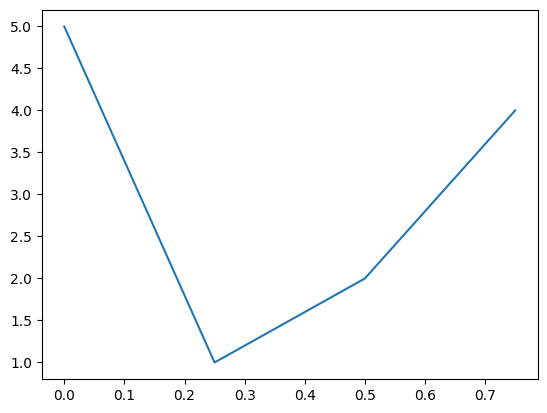

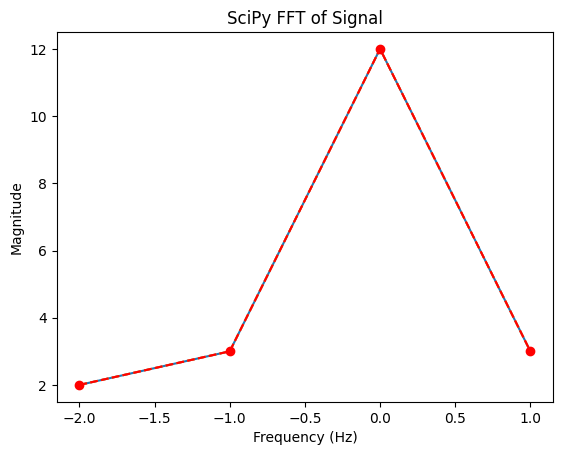

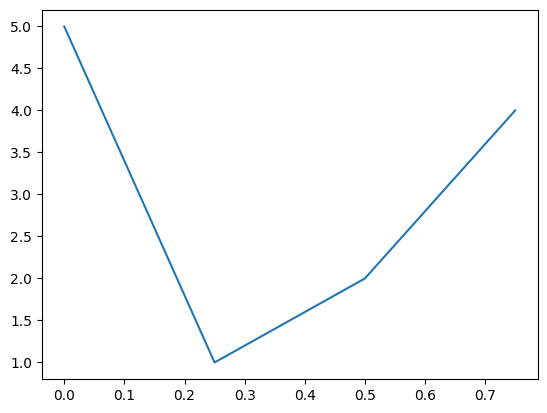

In [3]:
from matplotlib import pyplot as plt
import scipy.fft as scipyFFT

DEBUG_DFT = False
DEBUG_FFT_R2 = False
def myDFT(signal : list) -> list:
    fft = []
    N = len(signal)
    if DEBUG_DFT:
        print("********** DEBUG DFT BEGIN **********")
    for idx, component in enumerate(signal):
        n = component
        fft.append(0)
        if DEBUG_DFT:
            print("[", end="")
        for jdx, sample in enumerate(signal):
            exponential = np.exp(-(1j * 2 * np.pi * idx * jdx) / N)
            fft[idx] += signal[jdx] * exponential
            if DEBUG_DFT:
                print(f"{signal[jdx] * exponential}", end=", ")
        if DEBUG_DFT:
            print("]", end="")
            print(f" | F{idx} Result = {fft[idx]}")
    if DEBUG_DFT:
        print("********** DEBUG DFT BEGIN **********")
    return fft

def myFFT_Radix2(x):
    if DEBUG_FFT_R2:
        print("***** FFT Radix2 Called with size {N} *****")
    x = np.array(x, dtype=complex)
    N = int(len(x))
    if N == 1:
        return x
    k = np.arange(N//2)
    W = np.exp(-2j*np.pi*k/N)
    if DEBUG_FFT_R2:
        print(f"W = {W}")
    evens = myFFT_Radix2(x[0::2])
    odds = myFFT_Radix2(x[1::2])

    out_first = evens + (W * odds)
    out_second = evens - (W * odds)
    if DEBUG_FFT_R2:
        print(f"signal = {x}; len w = {len(W)}")
        print(f"first = {out_first}; second = {out_second}")
        print(f"Len in  = {N}; len out = {len(out_first) + len(out_second)}")

    return np.concatenate([out_first, out_second])

def radix2_fft(signal):
    # Elijah's implementation
    N = len(signal)
    
    # Check if N is a power of 2
    if N <= 0 or (N & (N - 1)) != 0:
        raise ValueError("Signal length must be a power of 2")
    
    # Base case: 1-point FFT is just the signal itself
    if N == 1:
        return signal
    
    # Bit-reversal permutation (reorder input for in-place splitting)
    # NOTE: This step can increase optimization by improving locality of 
    # FFT chunks, though it is a bit unnecessary for the example implementation
    # Confusing as hell...
    def bit_reverse(n, bits):
        # local function to radix-2
        reversed = 0
        for i in range(bits):
            if (n >> i) & 1:
                reversed |= 1 << (bits - 1 - i)
        return reversed
    
    # Reorder signal
    stages = int(np.log2(N))
    output = [0] * N
    for i in range(N):
        output[bit_reverse(i, stages)] = signal[i]
    
    # Iterative FFT: Build from 2-point DFTs up to N-point
    for size in range(1, stages + 1):
        block_size = 1 << size  # 2, 4, 8, ...
        half_size = block_size // 2
        
        # Process each block
        for start in range(0, N, block_size):
            # Butterfly operations within block
            for k in range(half_size):
                even_idx = start + k
                odd_idx = start + k + half_size
                even_val = output[even_idx]
                # Twiddle factor: W_N^k = e^(-2πi k / block_size)
                twiddle = np.exp(-2j * np.pi * k / block_size)
                odd_val = twiddle * output[odd_idx]
                
                # Combine: X[k] = even + W * odd, X[k + N/2] = even - W * odd
                output[even_idx] = even_val + odd_val
                output[odd_idx] = even_val - odd_val
    
    return output

samplingFreq = 4
duration = 1
N = int(samplingFreq * duration)

time = np.linspace(0, duration, N, endpoint=False)
#signal = np.sin(10.0 * 2.0*np.pi*time) + 0.5*np.sin(25.0 * 2.0*np.pi*time)
signal = [5, 1, 2, 4]

signalFFT = scipyFFT.fft(signal)
mySignalFFT = myDFT(signal)
mySignalFFT_R2 = myFFT_Radix2(signal)
#mySignalFFT_R2 = radix2_fft(signal)#myFFT_Radix2(signal)

print(f"SciPy FFT: {signalFFT}")
print(f"My FFT: {np.array(mySignalFFT)}")
print(f"My FFT_R2: {mySignalFFT_R2}")

fft_freq = scipyFFT.fftfreq(N, 1/samplingFreq)
fft_freq_shift = scipyFFT.fftshift(fft_freq)

signalFFT_shift = scipyFFT.fftshift(signalFFT)
mySignalFFT_shift = scipyFFT.fftshift(mySignalFFT)
mySignalFFT_R2_shift = scipyFFT.fftshift(mySignalFFT_R2)

plt.figure(1)
plt.plot(time, signal)
plt.figure(2)
plt.plot(fft_freq_shift, signalFFT_shift)
plt.plot(fft_freq_shift, mySignalFFT_shift, "--")
plt.plot(fft_freq_shift, mySignalFFT_R2_shift, "--ro")
# Display only positive frequencies (MUST MULTIPLY MAGNITUDE BY 2)
# plt.xlim(0, samplingFreq/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("SciPy FFT of Signal")

plt.figure(3)
plt.plot(time, scipyFFT.ifft(signalFFT))



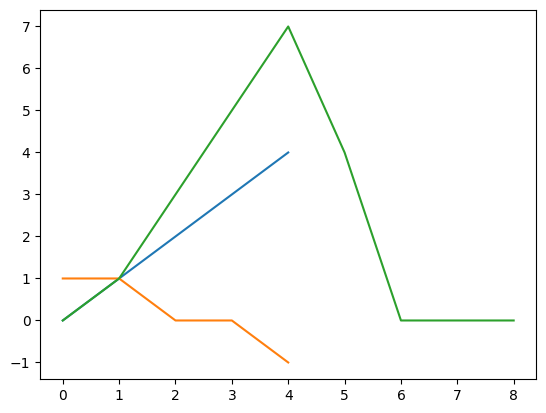

In [6]:
from matplotlib import pyplot as plt
x = range(5)
x2 = range(9)

plt.plot(x, a, x, b, x2, c)

In [7]:
import numpy as np
def myconv (a, b, type="full") :
    if type != "full" : # Implements "Valid" Convolution
        c = np.zeros(len(a) - len(b) + 1)
        for i in range(len(c)):
            for j in range (len(b)):
                    c[i] += a[i + j ] * b[j]
        return c
    else: # Implements "Full" convolution
        c = np.zeros(len(a) + len(b) - 1)
        for i in range(len(c)):
            for j in range (len(b)):
                a_idx = i - (len(b) - 1 - j)
                if 0 <= a_idx < len(a) : # Bounds check, zero pad emulated
                    c[i] += a[a_idx] * b[len(b) - j - 1]
        return c

def my_overlap_add(a, b, l):
    convs = np.zeros(len(a) + len(b) - 1)
    for i in range(0, len(a), l):
        conv = myconv(a[i:i + l], b)  
        for j, val in enumerate(conv):
            convs[i + j] += val

    return convs

def my_overlap_save(a, b, l):
    m = len(b) - 1
    result = []
    for i in range (0, len(a), l):
        if i +l + m < len(a) :
            result.extend( myconv(a[i:i+l + m], b, type="valid"))
        else:
            result.extend( myconv(a[i:], b, type="valid"))

    return result


In [8]:
a = np.array(range(5))
b = np.zeros(shape=(5))
b[0] = 1
b[1] = 1
b[4] = -1
print(f"numpy: {np.convolve(a, b)}")
print(f"basic conv : {myconv(a, b)}")
print(f"overlap add : {my_overlap_add(a, b, 3)}")
print(f"overlap save : {my_overlap_save(list(a), [1, 1], 3)}")

numpy: [ 0.  1.  3.  5.  7.  3. -2. -3. -4.]
basic conv : [ 0.  1.  3.  5.  7.  3. -2. -3. -4.]
overlap add : [ 0.  1.  3.  5.  7.  3. -2. -3. -4.]
overlap save : [np.float64(1.0), np.float64(3.0), np.float64(5.0), np.float64(7.0)]


In [12]:
import convexa
print(convexa.host_convolve([3.0, 4.0, 1.0], [5.0, 6.0, 10.0]))

print(convexa.host_dft([5.0, 1.0, 2.0, 4.0]))

[3.0, 4.0, 1.0]
[5.0, 1.0, 2.0, 4.0]
